# myChEMBL webservices version 2.x

### myChEMBL team, ChEMBL Group, EMBL-EBI.

## Introduction

This notebook will provide some examples of using the **`myChEMBL`** webservices.

The web services have recently been updated to the 2.x version and are **not** backwards compatible.
The main features introduced by this latest version are:

 - more resources
 - filtering
 - paging
 - ordering
 
You can call the web services in the following two ways: 
 
1) Directly _via_ URLs (see the 'Web Services' link on the **`myChEMBL`** LaunchPad for a list of the available endpoints). The advantage of using the URLs is that it is language-agnostic: although the examples below use Python, any other language with a library for executing HTTP requests would do just as well.


2) Using the API provided by the Python package **`chembl_webresource_client`**. This has the following advantages:
 - the usage is simpler
 - some extra functionality is available
 - there are performance benefits

For the reasons above, we recommend using the API where possible.

Note that the **`chembl_webresource_client`** module is aleady installed on the **`myChEMBL`** VM; if you wish to use it on other machines, it can be installed using **`pip`**.

Please note that the code below attempts to balance clarity and brevity, and is not intended to be a template for production code: error checking, for example, should be much more thorough in practice. 

## Configuration and setup

In [1]:
import logging

from collections import Counter
from operator import itemgetter

from lxml import etree

from rdkit import Chem
from rdkit.Chem import Draw 
from rdkit.Chem.Draw import IPythonConsole

from IPython.display import Image, display

In [2]:
# Python modules used for API access...
# By default, the API connects to the main ChEMBL database; set it to use the local version (i.e. myChEMBL) instead...
from chembl_webresource_client.settings import Settings
Settings.Instance().NEW_CLIENT_URL = 'http://localhost/chemblws'

from chembl_webresource_client.new_client import new_client

## List of available resources
It's easy to get a list of available resources by invoking:

In [3]:
available_resources = [resource for resource in dir(new_client) if not resource.startswith('_')]
print available_resources
print len(available_resources)

['activity', 'assay', 'atc_class', 'binding_site', 'biotherapeutic', 'cell_line', 'chembl_id_lookup', 'description', 'document', 'drug_indication', 'go_slim', 'image', 'mechanism', 'metabolism', 'molecule', 'molecule_form', 'official', 'protein_class', 'similarity', 'source', 'substructure', 'target', 'target_component']
23


Which means there are 20 different types of resources available _via_ web services. In this notebook only the most important of these are covered.

## Molecules

Molecule records may be retrieved in a number of ways, such as lookup of single molecules using various identifiers or searching for compounds _via_ substruture or similarity. 

In [4]:
# Get a molecule-handler object for API access and check the connection to the database...

molecule = new_client.molecule
molecule.set_format('json')
print "%s molecules available in myChEMBL_20" % len(molecule.all())

1592191 molecules available in myChEMBL_20


### Getting a single molecule

In order to retrieve a single molecule from the web services, you need to know its unique and unambiguous identifier. In case of molecule resource this can be one of three types:

 1. ChEMBL_ID
 2. InChI Key
 3. Canonical SMILES (non-canonical SMILES will be covered later in this notebook)

In [5]:
# so this:
# 1.
m1 = molecule.get('CHEMBL25')
# 2.
m2 = molecule.get('BSYNRYMUTXBXSQ-UHFFFAOYSA-N')
#
m3 = molecule.get('CC(=O)Oc1ccccc1C(=O)O')
# will return the same data:
m1 == m2 == m3

True

### ChEMBL ID

All the main entities in the ChEMBL database have a ChEMBL ID. It is a stable identifier designed for straightforward lookup of data.

In [6]:
# Lapatinib, the bioactive component of the anti-cancer drug Tykerb

chembl_id = "CHEMBL554" 

In [7]:
# Get compound record using client...

record_via_client = molecule.get(chembl_id)

record_via_client

{u'atc_classifications': [u'L01XE07'],
 u'availability_type': u'1',
 u'biotherapeutic': None,
 u'black_box_warning': u'1',
 u'chebi_par_id': 49603,
 u'chirality': u'2',
 u'dosed_ingredient': False,
 u'first_approval': 2007,
 u'first_in_class': u'0',
 u'helm_notation': None,
 u'indication_class': None,
 u'inorganic_flag': u'0',
 u'max_phase': 4,
 u'molecule_chembl_id': u'CHEMBL554',
 u'molecule_hierarchy': {u'molecule_chembl_id': u'CHEMBL554',
  u'parent_chembl_id': u'CHEMBL554'},
 u'molecule_properties': {u'acd_logd': u'6.26',
  u'acd_logp': u'6.30',
  u'acd_most_apka': None,
  u'acd_most_bpka': u'6.34',
  u'alogp': u'6.04',
  u'aromatic_rings': 5,
  u'full_molformula': u'C29H26ClFN4O4S',
  u'full_mwt': u'581.06',
  u'hba': 7,
  u'hbd': 2,
  u'heavy_atoms': 40,
  u'molecular_species': u'NEUTRAL',
  u'mw_freebase': u'581.06',
  u'mw_monoisotopic': u'580.1347',
  u'num_alerts': 1,
  u'num_ro5_violations': 2,
  u'psa': u'114.73',
  u'qed_weighted': u'0.18',
  u'ro3_pass': u'N',
  u'rtb': 

As noted above, a URLs may also be used to access the data, and, although the examples here use Python, any other language with a library for executing HTTP requests would do as well.

In [8]:
# Import a Python module to allow URL-based access...

import requests
from urllib import quote

# Stem of URL for local version of web services...

url_stem = "http://localhost/chemblws"

In [9]:
# Note that, for historical reasons, the URL-based webservices return XML by default, so JSON
# must be requested explicity by appending '.json' to the URL.

# Get request object...
url = url_stem + "/molecule/" + chembl_id + ".json"
request = requests.get(url)

print url

# Check reqest status: should be 200 if everything went OK...
print request.status_code

http://localhost/chemblws/molecule/CHEMBL554.json
200


In [10]:
record_via_url = request.json()
record_via_url 

{u'atc_classifications': [u'L01XE07'],
 u'availability_type': u'1',
 u'biotherapeutic': None,
 u'black_box_warning': u'1',
 u'chebi_par_id': 49603,
 u'chirality': u'2',
 u'dosed_ingredient': False,
 u'first_approval': 2007,
 u'first_in_class': u'0',
 u'helm_notation': None,
 u'indication_class': None,
 u'inorganic_flag': u'0',
 u'max_phase': 4,
 u'molecule_chembl_id': u'CHEMBL554',
 u'molecule_hierarchy': {u'molecule_chembl_id': u'CHEMBL554',
  u'parent_chembl_id': u'CHEMBL554'},
 u'molecule_properties': {u'acd_logd': u'6.26',
  u'acd_logp': u'6.30',
  u'acd_most_apka': None,
  u'acd_most_bpka': u'6.34',
  u'alogp': u'6.04',
  u'aromatic_rings': 5,
  u'full_molformula': u'C29H26ClFN4O4S',
  u'full_mwt': u'581.06',
  u'hba': 7,
  u'hbd': 2,
  u'heavy_atoms': 40,
  u'molecular_species': u'NEUTRAL',
  u'mw_freebase': u'581.06',
  u'mw_monoisotopic': u'580.1347',
  u'num_alerts': 1,
  u'num_ro5_violations': 2,
  u'psa': u'114.73',
  u'qed_weighted': u'0.18',
  u'ro3_pass': u'N',
  u'rtb': 

Note that in both cases we are getting exactly the same results:

In [11]:
record_via_client == record_via_url

True

When retrieved in JSON format, a record is a nested dictionary, so to get, say, a SMILES string we have to write:

In [12]:
smiles_from_json = record_via_client['molecule_structures']['canonical_smiles']

It is possible to retrieve data in XML format as well:

In [13]:
# Get compound record in XML format...

molecule.set_format('xml')
xml = molecule.get(chembl_id).encode('utf-8')
#print xml
# The XML must be parsed (e.g. using the lxml.etree module in Python) to enable extraction of the data...

root = etree.fromstring(xml).getroottree()

In [14]:
# Extract SMILES via xpath...

smiles_from_xml = root.xpath("/molecule/molecule_structures/canonical_smiles/text()")[0]

print smiles_from_xml
print smiles_from_xml == smiles_from_json

CS(=O)(=O)CCNCc1oc(cc1)c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2
True


In [15]:
# Pretty-print XML...

print etree.tostring(root, pretty_print=True)

<molecule>
  <atc_classifications>
    <level5>L01XE07</level5>
  </atc_classifications>
  <availability_type>1</availability_type>
  <biotherapeutic/>
  <black_box_warning>1</black_box_warning>
  <chebi_par_id>49603</chebi_par_id>
  <chirality>2</chirality>
  <dosed_ingredient/>
  <first_approval>2007</first_approval>
  <first_in_class>0</first_in_class>
  <helm_notation/>
  <indication_class/>
  <inorganic_flag>0</inorganic_flag>
  <max_phase>4</max_phase>
  <molecule_chembl_id>CHEMBL554</molecule_chembl_id>
  <molecule_hierarchy>
    <molecule_chembl_id>CHEMBL554</molecule_chembl_id>
    <parent_chembl_id>CHEMBL554</parent_chembl_id>
  </molecule_hierarchy>
  <molecule_properties>
    <acd_logd>6.26</acd_logd>
    <acd_logp>6.30</acd_logp>
    <acd_most_apka/>
    <acd_most_bpka>6.34</acd_most_bpka>
    <alogp>6.04</alogp>
    <aromatic_rings>5</aromatic_rings>
    <full_molformula>C29H26ClFN4O4S</full_molformula>
    <full_mwt>581.06</full_mwt>
    <hba>7</hba>
    <hbd>2</hbd>
   

### InChIKey

Compound records may also be retrieved _via_ InChI Key lookup.

In [16]:
# InChI Key for Lapatinib
inchi_key = "BCFGMOOMADDAQU-UHFFFAOYSA-N"

# getting molecule via client
molecule.set_format('json')
record_via_client = molecule.get(inchi_key)

# getting molecule via url
url = url_stem + "/molecule/" + inchi_key + ".json"
record_via_url = requests.get(url).json()

print url

# they are the same
print record_via_url == record_via_client

http://localhost/chemblws/molecule/BCFGMOOMADDAQU-UHFFFAOYSA-N.json
True


### SMILES

Compound records may also be retrieved _via_ SMILES lookup.

The purpose of the `get` method is to return objects identified by their unique and unambiguous properties.
This is why SMILES provided as arguments to the `get` method need to be canonical.
But you can still search for molecules, using non-canonical SMILES - this functionaly will be covered later in this notebook.

In [17]:
# Canonoical SMILES for Lapatinib
canonical_smiles = "CS(=O)(=O)CCNCc1oc(cc1)c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2"

# getting molecule via client
molecule.set_format('json')
record_via_client = molecule.get(canonical_smiles)

# getting molecule via url
url = url_stem + "/molecule/" + quote(canonical_smiles) + ".json"
record_via_url = requests.get(url).json()

print url

# they are the same
record_via_url == record_via_client

http://localhost/chemblws/molecule/CS%28%3DO%29%28%3DO%29CCNCc1oc%28cc1%29c2ccc3ncnc%28Nc4ccc%28OCc5cccc%28F%29c5%29c%28Cl%29c4%29c3c2.json


True

### Batch queries

Multiple records may be requested at once. The `get` method can accept a list of homogenous identifiers.

In [18]:
records1 = molecule.get(['CHEMBL6498', 'CHEMBL6499', 'CHEMBL6505'])
records2 = molecule.get(['XSQLHVPPXBBUPP-UHFFFAOYSA-N', 'JXHVRXRRSSBGPY-UHFFFAOYSA-N', 'TUHYVXGNMOGVMR-GASGPIRDSA-N'])
records3 = molecule.get(['CNC(=O)c1ccc(cc1)N(CC#C)Cc2ccc3nc(C)nc(O)c3c2',
            'Cc1cc2SC(C)(C)CC(C)(C)c2cc1\\N=C(/S)\\Nc3ccc(cc3)S(=O)(=O)N',
            'CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H]3CCCN3C(=O)C(CCCCN)CCCCN)C(C)(C)C)C(=O)O'])
records1 == records2 == records3

True

The same can be done _via_ urls:

In [19]:
url1 = url_stem + "/molecule/set/%s;%s;%s" % ('CHEMBL6498', 'CHEMBL6499', 'CHEMBL6505') + ".json"
records1 = requests.get(url1).json()

url2 = url_stem + "/molecule/set/%s;%s;%s" % ('XSQLHVPPXBBUPP-UHFFFAOYSA-N', 'JXHVRXRRSSBGPY-UHFFFAOYSA-N', 'TUHYVXGNMOGVMR-GASGPIRDSA-N') + ".json"
records2 = requests.get(url2).json()

url3 = url_stem + "/molecule/set/%s;%s;%s" % (quote('CNC(=O)c1ccc(cc1)N(CC#C)Cc2ccc3nc(C)nc(O)c3c2'),
            quote('Cc1cc2SC(C)(C)CC(C)(C)c2cc1\\N=C(/S)\\Nc3ccc(cc3)S(=O)(=O)N'),
            quote('CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H]3CCCN3C(=O)C(CCCCN)CCCCN)C(C)(C)C)C(=O)O')) + ".json"
records3 = requests.get(url3).json()

print url1
print url2
print url3

records1 == records2 == records3


http://localhost/chemblws/molecule/set/CHEMBL6498;CHEMBL6499;CHEMBL6505.json
http://localhost/chemblws/molecule/set/XSQLHVPPXBBUPP-UHFFFAOYSA-N;JXHVRXRRSSBGPY-UHFFFAOYSA-N;TUHYVXGNMOGVMR-GASGPIRDSA-N.json
http://localhost/chemblws/molecule/set/CNC%28%3DO%29c1ccc%28cc1%29N%28CC%23C%29Cc2ccc3nc%28C%29nc%28O%29c3c2;Cc1cc2SC%28C%29%28C%29CC%28C%29%28C%29c2cc1%5CN%3DC%28/S%29%5CNc3ccc%28cc3%29S%28%3DO%29%28%3DO%29N;CC%28C%29C%5BC%40H%5D%28NC%28%3DO%29%5BC%40%40H%5D%28NC%28%3DO%29%5BC%40H%5D%28Cc1c%5BnH%5Dc2ccccc12%29NC%28%3DO%29%5BC%40H%5D3CCCN3C%28%3DO%29C%28CCCCN%29CCCCN%29C%28C%29%28C%29C%29C%28%3DO%29O.json


True

Please note that the length of url can't be more than 4000 characters. This is why url-based approach should not be used for a very long lists of identifiers. Also `molecule.get` call needs to be modified slightly in that case.

In [20]:
# Generate a list of 300 ChEMBL IDs (N.B. not all will be valid)...

chembl_ids = ['CHEMBL{}'.format(x) for x in range(1, 301)]

# Get compound records, note `molecule_chembl_id` named parameter.
# Named parameters should always be used for longer lists

records = molecule.get(molecule_chembl_id=chembl_ids)

len(records)

168

Note that we expect to see a number that is less than 300 (169). This is because for some identifiers in range `(CHEMBL1, ..., CHEMBL300)` there are no molecule mapped to them.

### Filtering
All resources available through ChEMBL web services can be filtered.
Some examples of filtering applied to molecules:

1. Get all approved drugs
2. Get all molecules in ChEMBL with no Rule-of-Five violations
3. Get all biotherapeutic molecules
4. Return molecules with molecular weight <= 300
5. Return molecules with molecular weight <= 300 AND pref_name ends with -nib

In [21]:
# First, filtering using the client:

# 1. Get all approved drugs
approved_drugs = molecule.filter(max_phase=4)

# 2. Get all molecules in ChEMBL with no Rule-of-Five violations
no_violations = molecule.filter(molecule_properties__num_ro5_violations=0)

# 3. Get all biotherapeutic molecules
biotherapeutics = molecule.filter(biotherapeutic__isnull=False)

# 4. Return molecules with molecular weight <= 300
light_molecules = molecule.filter(molecule_properties__mw_freebase__lte=300)

# 5. Return molecules with molecular weight <= 300 AND pref_name ends with nib
light_nib_molecules = molecule.filter(molecule_properties__mw_freebase__lte=300).filter(pref_name__iendswith="nib")

In [22]:
# Secondly, fltering using url endpoint:

# 1. Get all approved drugs
url_1 = url_stem + "/molecule.json?max_phase=4"
url_approved_drugs = requests.get(url_1).json()

# 2. Get all molecules in ChEMBL with no Rule-of-Five violations
url_2 = url_stem + "/molecule.json?molecule_properties__num_ro5_violations=0"
ulr_no_violations = requests.get(url_2).json()

# 3. Get all biotherapeutic molecules
url_3 = url_stem + "/molecule.json?biotherapeutic__isnull=false"
url_biotherapeutics = requests.get(url_3).json()

# 4. Return molecules with molecular weight <= 300
url_4 = url_stem + "/molecule.json?molecule_properties__mw_freebase__lte=300"
url_light_molecules = requests.get(url_4).json()

# 5. Return molecules with molecular weight <= 300 AND pref_name ends with nib
url_5 = url_stem + "/molecule.json?molecule_properties__mw_freebase__lte=300&pref_name__iendswith=nib"
url_light_nib_molecules = requests.get(url_5).json()

print url_1
print url_2
print url_3
print url_4
print url_5

http://localhost/chemblws/molecule.json?max_phase=4
http://localhost/chemblws/molecule.json?molecule_properties__num_ro5_violations=0
http://localhost/chemblws/molecule.json?biotherapeutic__isnull=false
http://localhost/chemblws/molecule.json?molecule_properties__mw_freebase__lte=300
http://localhost/chemblws/molecule.json?molecule_properties__mw_freebase__lte=300&pref_name__iendswith=nib


### Deferences between filtering with client and url endpoint - paging
There are some important differences between filering results returned by the client and generated using URL endpoint.
Let's have a look at them.

In [23]:
# First off, they are not the same thing:
print approved_drugs == url_approved_drugs

# Not surprisingly, url-endpoint produced JSON data, which has been paresed into python dict:
print type(url_approved_drugs)

# Whereas the client has returned an object of type `QuerySet`
print type(approved_drugs)

False
<type 'dict'>
<class 'chembl_webresource_client.query_set.QuerySet'>


In [24]:
# Let's examine what data contains the python dict:
url_approved_drugs

{u'molecules': [{u'atc_classifications': [u'C02CA01'],
   u'availability_type': u'1',
   u'biotherapeutic': None,
   u'black_box_warning': u'0',
   u'chebi_par_id': 8364,
   u'chirality': u'2',
   u'dosed_ingredient': False,
   u'first_approval': 1976,
   u'first_in_class': u'0',
   u'helm_notation': None,
   u'indication_class': u'Antihypertensive',
   u'inorganic_flag': u'0',
   u'max_phase': 4,
   u'molecule_chembl_id': u'CHEMBL2',
   u'molecule_hierarchy': {u'molecule_chembl_id': u'CHEMBL2',
    u'parent_chembl_id': u'CHEMBL2'},
   u'molecule_properties': {u'acd_logd': u'2.09',
    u'acd_logp': u'2.14',
    u'acd_most_apka': None,
    u'acd_most_bpka': u'6.52',
    u'alogp': u'2.11',
    u'aromatic_rings': 3,
    u'full_molformula': u'C19H21N5O4',
    u'full_mwt': u'383.40',
    u'hba': 7,
    u'hbd': 1,
    u'heavy_atoms': 28,
    u'molecular_species': u'NEUTRAL',
    u'mw_freebase': u'383.40',
    u'mw_monoisotopic': u'383.1594',
    u'num_alerts': 0,
    u'num_ro5_violations': 0

### Page structure

The dictionary contains two top-level keys:

1. `molecules` array
2. `page_meta` dictionary

This  means that by requesting data from the url-endpoint we are not getting the whole result set but a single page.
The page consists of a single portion of data (`molecules` array) and some meta information about the page and whole result set (`page_meta` dictionary).

In [25]:
# The default size of single page is 20 results:
len(url_approved_drugs['molecules'])

20

In [26]:
# But it can be extended up to 1000 results by providing `limit` argument:
url = url_stem + "/molecule.json?max_phase=4&limit=200"
bigger_page = requests.get(url).json()

print url
print len(bigger_page['molecules'])

http://localhost/chemblws/molecule.json?max_phase=4&limit=200
200


In [27]:
#Let's see what data is provided in `page-meta` dictionary:
url_approved_drugs['page_meta']

{u'limit': 20,
 u'next': u'/chemblws/molecule.json?max_phase=4&limit=20&offset=20',
 u'offset': 0,
 u'previous': None,
 u'total_count': 2879}

It gives following information:
1. `limit` - current size of the page (the actual amount of data can be smaller if the whole result set is smaller than page size or we are looking at the last page)
2. `offset` - the difference between first element in the whole result set and the first element on current page 
3. `next` - url poiting to the next page (if it exists)
4. `previous` - url pointing to the previous page (if it exists)
5. `total_count` - number of elements in the whole result set

This means that in order to get the whole result set we need to loop through the pages:

In [28]:
# Getting all approved drugs using url endpoint
localhost = "http://localhost/"
url_approved_drugs = requests.get(localhost + "chemblws/molecule.json?max_phase=4&limit=1000").json()
results = url_approved_drugs['molecules']
while url_approved_drugs['page_meta']['next']:
    url_approved_drugs = requests.get(localhost + url_approved_drugs['page_meta']['next']).json()
    results += url_approved_drugs['molecules']
print len(results)
print len(results) == url_approved_drugs['page_meta']['total_count']

2879
True


With the client-generated results, we no longer have to worry about pagination:

In [29]:
# The QuerySet object returned by the client is a lazily-evaluated iterator
# This means that it's ready to use and it will try to reduce the amount of server requests
# All results are cached as well so they are fetched from server only once.
approved_drugs = molecule.filter(max_phase=4)

# Getting the lenght of the whole result set is easy:
print len(approved_drugs)

# So is getting a single element:
print approved_drugs[123]

# Or a chunk of elements:
print approved_drugs[2:5]

# Or using in the loops or list comprehensions:
drug_smiles = [drug['molecule_structures']['canonical_smiles'] for drug in approved_drugs if drug['molecule_structures']]
print len(drug_smiles)

2879
{u'max_phase': 4, u'usan_stem': u'-ifen(e)', u'parenteral': False, u'dosed_ingredient': False, u'molecule_type': u'Small molecule', u'biotherapeutic': None, u'chebi_par_id': 41774, u'first_approval': 1977, u'atc_classifications': [u'L02BA01'], u'prodrug': u'1', u'molecule_structures': {u'standard_inchi_key': u'NKANXQFJJICGDU-QPLCGJKRSA-N', u'canonical_smiles': u'CC\\C(=C(/c1ccccc1)\\c2ccc(OCCN(C)C)cc2)\\c3ccccc3', u'standard_inchi': u'InChI=1S/C26H29NO/c1-4-25(21-11-7-5-8-12-21)26(22-13-9-6-10-14-22)23-15-17-24(18-16-23)28-20-19-27(2)3/h5-18H,4,19-20H2,1-3H3/b26-25-'}, u'chirality': u'2', u'usan_substem': None, u'pref_name': u'TAMOXIFEN', u'polymer_flag': False, u'molecule_chembl_id': u'CHEMBL83', u'therapeutic_flag': True, u'molecule_properties': {u'num_ro5_violations': 1, u'mw_freebase': u'371.51', u'psa': u'12.47', u'full_mwt': u'371.51', u'ro3_pass': u'N', u'num_alerts': 1, u'acd_logd': u'2.79', u'full_molformula': u'C26H29NO', u'hba': 2, u'molecular_species': u'NEUTRAL', u'mw

### Ordering results
Similar to filtering, it's also possible to order the result set, there is a parameter called `order_by` that is reposnsible for ordering:

In [30]:
# Sort approved drugs by molecular weight ascending (from lightest to heaviest) and get the first (lightest) element
lightest_drug = molecule.filter(max_phase=4).order_by('molecule_properties__mw_freebase')[0]
lightest_drug['pref_name']

u'AMMONIA N 13'

In [31]:
# Sort approved drugs by molecular weight descending (from heaviest to lightest) and get the first (heaviest) element
heaviest_drug = molecule.filter(max_phase=4).order_by('-molecule_properties__mw_freebase')[0]
heaviest_drug['pref_name']

u'INSULIN LISPRO PROTAMINE RECOMBINANT'

In [32]:
# Do the same using url endpoint
url_1 = url_stem + "/molecule.json?max_phase=4&order_by=molecule_properties__mw_freebase"
lightest_drug = requests.get(url_1).json()['molecules'][0]
print url_1
print lightest_drug['pref_name']

url_2 = url_stem + "/molecule.json?max_phase=4&order_by=-molecule_properties__mw_freebase"
heaviest_drug = requests.get(url_2).json()['molecules'][0]
print url_2
print heaviest_drug['pref_name']

http://localhost/chemblws/molecule.json?max_phase=4&order_by=molecule_properties__mw_freebase
AMMONIA N 13
http://localhost/chemblws/molecule.json?max_phase=4&order_by=-molecule_properties__mw_freebase
INSULIN LISPRO PROTAMINE RECOMBINANT


### Filtering molecules using SMILES
It is possible to filter molecules by SMILES

In [33]:
# Atorvastatin...
smiles = "CC(C)c1c(C(=O)Nc2ccccc2)c(c3ccccc3)c(c4ccc(F)cc4)n1CC[C@@H](O)C[C@@H](O)CC(=O)O"

# By default, the type of search used is 'exact search' which means that only compounds with exacly same SMILES string will be picked:
result = molecule.filter(molecule_structures__canonical_smiles=smiles)
print len(result)

# This is quivalent of:
result1 = molecule.filter(molecule_structures__canonical_smiles__exact=smiles)
print len(result1)

# For convenience, we have a shortcut call:
result2 = molecule.filter(smiles=smiles)
print len(result2)

# Checking if they are all the same: 
print result[0]['pref_name'] == result1[0]['pref_name'] == result2[0]['pref_name']

# And because SMILES string are unique in ChEMBL, this is similar to:
result3 = molecule.get(smiles)
print result[0]['pref_name'] == result3['pref_name']

1
1
1
True
True


There are however different filtering operators that can be applied to SMILES; the most important one is called `flexmatch`, which will return all structures described by given SMILES string even if this is non-canonical SMILES.

In [34]:
# Flexmatch will look for structures that match given SMILES, ignoring stereo:
records = molecule.filter(molecule_structures__canonical_smiles__flexmatch=smiles)
print len(records)

for record in records:
    print("{:15s} : {}".format(record["molecule_chembl_id"], record['molecule_structures']['canonical_smiles']))

1
CHEMBL1487      : CC(C)c1c(C(=O)Nc2ccccc2)c(c3ccccc3)c(c4ccc(F)cc4)n1CC[C@@H](O)C[C@@H](O)CC(=O)O


Unlike with the exact string match, it is possible to retrieve multiple records when a SMILES is used for the `flexmatch` lookup (_i.e._ it is potentially one-to-many instead of one-to-one as the ID lookups are). This is due to the nature of `flexmatch`.

In our case two structures are returned, CHEMBL1487 (Atorvastatin) and CHEMBL1207181, which is the same structure as the former but with one of the two stereocentres undefined.

In [35]:
# The same can be achieved using url endpoint:

url_1 = url_stem + "/molecule.json?molecule_structures__canonical_smiles=" + quote(smiles)
url_2 = url_stem + "/molecule.json?molecule_structures__canonical_smiles__exact=" + quote(smiles)
url_3 = url_stem + "/molecule.json?smiles=" + quote(smiles)
url_4 = url_stem + "/molecule.json?molecule_structures__canonical_smiles__flexmatch=" + quote(smiles)

exact_match = requests.get(url_1).json()
explicit_exact_match = requests.get(url_2).json()
convenient_shortcut = requests.get(url_3).json()
flexmatch = requests.get(url_4).json()

print url_1
print len(exact_match['molecules'])

print url_2
print len(explicit_exact_match['molecules'])

print url_3
print len(convenient_shortcut['molecules'])

print url_4
print len(flexmatch['molecules'])

print exact_match == explicit_exact_match

http://localhost/chemblws/molecule.json?molecule_structures__canonical_smiles=CC%28C%29c1c%28C%28%3DO%29Nc2ccccc2%29c%28c3ccccc3%29c%28c4ccc%28F%29cc4%29n1CC%5BC%40%40H%5D%28O%29C%5BC%40%40H%5D%28O%29CC%28%3DO%29O
1
http://localhost/chemblws/molecule.json?molecule_structures__canonical_smiles__exact=CC%28C%29c1c%28C%28%3DO%29Nc2ccccc2%29c%28c3ccccc3%29c%28c4ccc%28F%29cc4%29n1CC%5BC%40%40H%5D%28O%29C%5BC%40%40H%5D%28O%29CC%28%3DO%29O
1
http://localhost/chemblws/molecule.json?smiles=CC%28C%29c1c%28C%28%3DO%29Nc2ccccc2%29c%28c3ccccc3%29c%28c4ccc%28F%29cc4%29n1CC%5BC%40%40H%5D%28O%29C%5BC%40%40H%5D%28O%29CC%28%3DO%29O
1
http://localhost/chemblws/molecule.json?molecule_structures__canonical_smiles__flexmatch=CC%28C%29c1c%28C%28%3DO%29Nc2ccccc2%29c%28c3ccccc3%29c%28c4ccc%28F%29cc4%29n1CC%5BC%40%40H%5D%28O%29C%5BC%40%40H%5D%28O%29CC%28%3DO%29O
1
True


#### A further note on SMILES searches

The URL-based example above used the HTTP GET method, which means the SMILES are passed _via_ the URL. This can cause problems where the SMILES inludes the '/', '\' or '#' characters, for example:

In [36]:
# CHEMBL477889
smiles = "[Na+].CO[C@@H](CCC#C\C=C/CCCC(C)CCCCC=C)C(=O)[O-]"

url = url_stem + "/molecule/" + smiles + ".json"
result = requests.get(url)

print url
print result.ok
print result.status_code

http://localhost/chemblws/molecule/[Na+].CO[C@@H](CCC#C\C=C/CCCC(C)CCCCC=C)C(=O)[O-].json
False
404


There are two solutions to this problem:

1. When using GET, use `urllib.quote` function
2. Use POST with `X-HTTP-Method-Override`: `GET` header

In [37]:
# Method one:
url = url_stem + "/molecule/" + quote(smiles) + ".json"
result_by_get = requests.get(url)

print url
print result_by_get.ok
print result_by_get.status_code

http://localhost/chemblws/molecule/%5BNa%2B%5D.CO%5BC%40%40H%5D%28CCC%23C%5CC%3DC/CCCC%28C%29CCCCC%3DC%29C%28%3DO%29%5BO-%5D.json
True
200


In [38]:
# Method two:
url = url_stem + "/molecule.json"
result_by_post = requests.post(url, data={"smiles": smiles}, headers={"X-HTTP-Method-Override": "GET"})

print result_by_post.ok
print result_by_post.status_code

True
200


In [39]:
print smiles
print result_by_post.json()
print result_by_get.json() == result_by_post.json()['molecules'][0]

[Na+].CO[C@@H](CCC#C\C=C/CCCC(C)CCCCC=C)C(=O)[O-]
{u'page_meta': {u'previous': None, u'total_count': 1, u'offset': 0, u'limit': 20, u'next': None}, u'molecules': [{u'max_phase': 0, u'usan_stem': None, u'parenteral': False, u'dosed_ingredient': False, u'molecule_type': u'Small molecule', u'biotherapeutic': None, u'chebi_par_id': None, u'first_approval': None, u'atc_classifications': [], u'prodrug': u'-1', u'molecule_structures': {u'standard_inchi_key': u'RLSXKIUQYFNFBI-PJZMSVRGSA-M', u'canonical_smiles': u'[Na+].CO[C@@H](CCC#C\\C=C/CCCC(C)CCCCC=C)C(=O)[O-]', u'standard_inchi': u'InChI=1S/C20H32O3.Na/c1-4-5-6-12-15-18(2)16-13-10-8-7-9-11-14-17-19(23-3)20(21)22;/h4,7-8,18-19H,1,5-6,10,12-17H2,2-3H3,(H,21,22);/q;+1/p-1/b8-7-;/t18?,19-;/m0./s1'}, u'chirality': u'-1', u'usan_substem': None, u'pref_name': None, u'polymer_flag': False, u'molecule_chembl_id': u'CHEMBL477889', u'therapeutic_flag': False, u'molecule_properties': {u'num_ro5_violations': 1, u'mw_freebase': u'320.47', u'psa': u'46.5

### Substructure-searching

As well as ID lookups, the web services may also be used to perform substructure searches. Currently, only SMILES-based searches are supported, although this could change if there is is a need for more powerful search abilities (_e.g._ SMARTS searching).

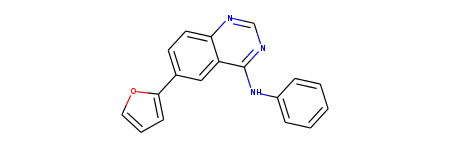

In [40]:
# Lapatinib contains the following core...

query = "c4ccc(Nc2ncnc3ccc(c1ccco1)cc23)cc4"

Chem.MolFromSmiles(query)

In [41]:
# Perform substructure search on query using client

substructure = new_client.substructure
records = substructure.filter(smiles=query)

In [42]:
# ... and using raw url-endpoint

url = url_stem + "/substructure/" + quote(query) + ".json"
result = requests.get(url).json()

print url
print result['page_meta']['total_count']

http://localhost/chemblws/substructure/c4ccc%28Nc2ncnc3ccc%28c1ccco1%29cc23%29cc4.json
82


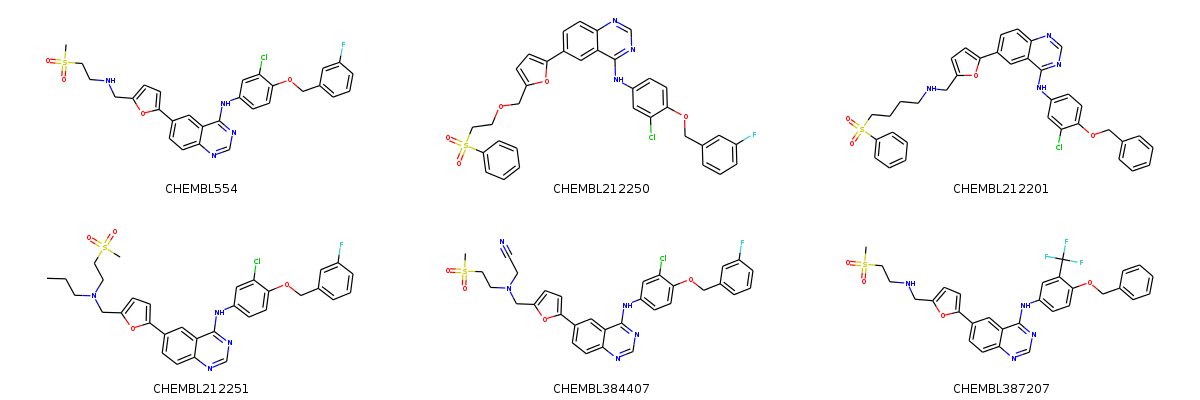

In [43]:
mols = [Chem.MolFromSmiles(x['molecule_structures']['canonical_smiles']) for x in records[:6]]
legends=[str(x["molecule_chembl_id"]) for x in records]
Draw.MolsToGridImage(mols, legends=legends, subImgSize=(400, 200), useSVG=False)

### Similarity searching

The web services may also be used to perform SMILES-based similarity searches.

In [44]:
# Lapatinib
smiles = "CS(=O)(=O)CCNCc1oc(cc1)c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2"

In [45]:
# Peform similarity search on molecule using client...

# Note that a percentage similarity must be supplied.
similarity = new_client.similarity
res = similarity.filter(smiles=smiles, similarity=85)

len(res)

7

In [46]:
##### ... and using raw url-endpoint

url = url_stem + "/similarity/" + quote(smiles) + "/85.json"
result = requests.get(url).json()

print url
print result['page_meta']['total_count']

http://localhost/chemblws/similarity/CS%28%3DO%29%28%3DO%29CCNCc1oc%28cc1%29c2ccc3ncnc%28Nc4ccc%28OCc5cccc%28F%29c5%29c%28Cl%29c4%29c3c2/85.json
7


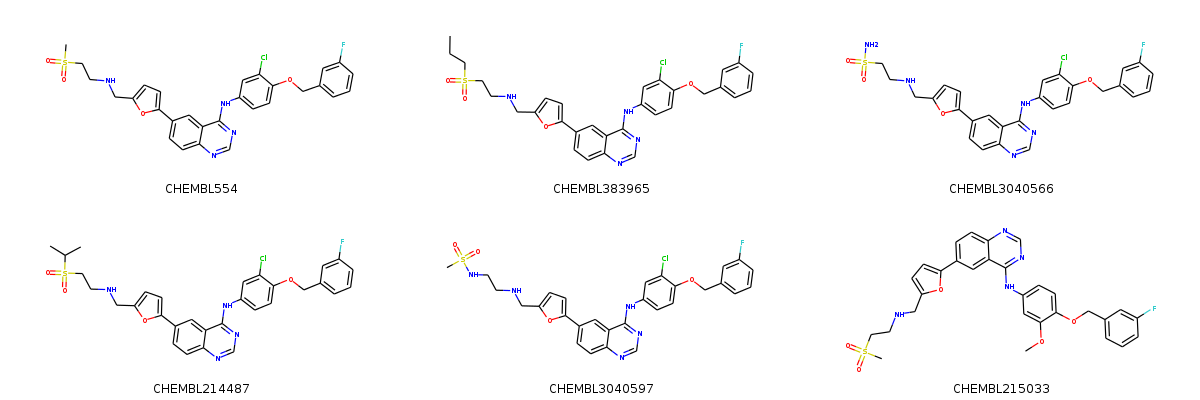

In [47]:
mols = [Chem.MolFromSmiles(x['molecule_structures']['canonical_smiles']) for x in res[:6]]
legends = [str(x["molecule_chembl_id"]) for x in res]
Draw.MolsToGridImage(mols, legends=legends, subImgSize=(400, 200), useSVG=False)

### Versions for a parent structure

The versions (_e.g._ salt forms) for a parent compound may be retrieved for a ChEMBL ID. Keep in mind that a parent structure is one that has had salt/solvate components removed; it corresponds to the bioactive moiety and its use facilitates structure searching, comparison _etc_. A compound without salt/solvate components is its own parent.

In [48]:
# Neostigmine (a parent)...

chembl_id = "CHEMBL278020" 

In [49]:
records = new_client.molecule_form.get(chembl_id)['molecule_forms']

records

[{u'molecule_chembl_id': u'CHEMBL278020', u'parent': u'True'},
 {u'molecule_chembl_id': u'CHEMBL54126', u'parent': u'False'},
 {u'molecule_chembl_id': u'CHEMBL211471', u'parent': u'False'}]

The ChEMBL ID lookup service may now be used to get the full records for the salt forms...

In [50]:
for chembl_id in [x["molecule_chembl_id"] for x in records if x["parent"] == 'False']:
    record = new_client.molecule.get(chembl_id)          
    print("{:10s} : {}".format(chembl_id, record['molecule_structures']['canonical_smiles']))

CHEMBL54126 : [Br-].CN(C)C(=O)Oc1cccc(c1)[N+](C)(C)C
CHEMBL211471 : COS(=O)(=O)[O-].CN(C)C(=O)Oc1cccc(c1)[N+](C)(C)C


### Drug mechanism(s) of action

The mechanisms of action of marketed drugs may be retrieved.

Note that this data may not be recorded for the parent structure, but rather for one of its versions. For example, the marketed drug, Tykerb, containing the active ingredient Lapatinib (CHEMBL554) is actually the ditosylate monohydrate (CHEMBL1201179).

In [51]:
# Molecule forms for Lapatinib are used here...

for chembl_id in (x["molecule_chembl_id"] for x in new_client.molecule_form.get("CHEMBL554")['molecule_forms']):
        
    print("The recorded mechanisms of action of '{}' are...".format(chembl_id))
        
    mechanism_records = new_client.mechanism.filter(molecule_chembl_id=chembl_id)
    
    if mechanism_records:
    
        for mech_rec in mechanism_records:
    
            print("{:10s} : {}".format(mech_rec["molecule_chembl_id"], mech_rec["mechanism_of_action"]))
        
    print("-" * 50)

The recorded mechanisms of action of 'CHEMBL554' are...
--------------------------------------------------
The recorded mechanisms of action of 'CHEMBL1201179' are...
CHEMBL1201179 : Receptor protein-tyrosine kinase erbB-2 inhibitor
CHEMBL1201179 : Epidermal growth factor receptor erbB1 inhibitor
--------------------------------------------------
The recorded mechanisms of action of 'CHEMBL3526325' are...
--------------------------------------------------
The recorded mechanisms of action of 'CHEMBL3542341' are...
--------------------------------------------------


### Image query

The webservice may be used to obtain a PNG image of a compound.

In [52]:
# Lapatinib ditosylate monohydrate (Tykerb)

chembl_id = "CHEMBL1201179" 

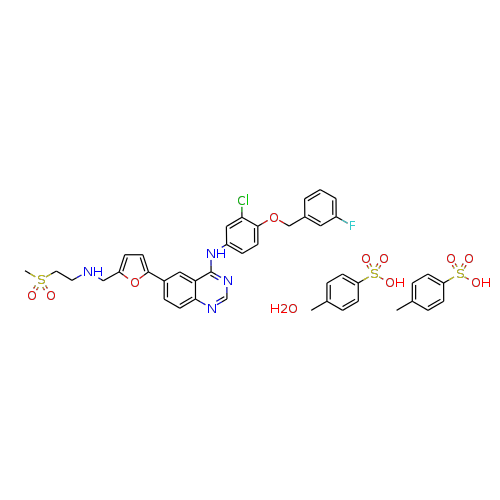

In [53]:
png = new_client.image.get(chembl_id)

Image(png)

### Bioactivities

All bioactivity records for a compound may be retrieved _via_ its ChEMBL ID.


In [54]:
# Lapatinib

chembl_id = "CHEMBL554" 

In [55]:
records = new_client.activity.filter(molecule_chembl_id=chembl_id)

len(records), records[:2]

(1749,
 [{u'document_journal': u'Bioorg. Med. Chem. Lett.', u'bao_endpoint': u'BAO_0000190', u'potential_duplicate': False, u'uo_units': u'UO_0000065', u'canonical_smiles': u'CS(=O)(=O)CCNCc1oc(cc1)c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2', u'assay_type': u'B', u'standard_flag': True, u'molecule_chembl_id': u'CHEMBL554', u'target_organism': u'Homo sapiens', u'assay_description': u'Inhibitory activity against epidermal growth factor receptor', u'record_id': 15408, u'document_chembl_id': u'CHEMBL1146682', u'bao_format': u'BAO_0000357', u'standard_units': u'nM', u'activity_id': 190221, u'standard_type': u'IC50', u'target_chembl_id': u'CHEMBL203', u'data_validity_comment': None, u'standard_relation': u'=', u'document_year': 2004, u'target_pref_name': u'Epidermal growth factor receptor erbB1', u'assay_chembl_id': u'CHEMBL674106', u'published_value': u'0.01', u'published_relation': u'=', u'standard_value': u'10', u'qudt_units': u'http://www.openphacts.org/units/Nanomolar', u'published_un

## Targets

The webservices may also be used to obtain information on biological targets, _i.e._ the entities, such as proteins, cells or organisms, with which compounds interact.


In [56]:
# Like with any other resource type, a complete list of targets can be requested using the client:
records = new_client.target.all()
len(records)

11019

In [57]:
records[:4]

[{u'target_components': [{u'component_id': 434, u'accession': u'O43451', u'component_type': u'PROTEIN', u'target_component_synonyms': [{u'component_synonym': u'MGA ', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'MGAML', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'MGAM', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'Maltase-glucoamylase, intestinal', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Maltase', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Glucoamylase', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Alpha-glucosidase', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Glucan 1,4-alpha-glucosidase', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'3.2.1.20', u'syn_type': u'EC_NUMBER'}, {u'component_synonym': u'3.2.1.3', u'syn_type': u'EC_NUMBER'}]}], u'target_chembl_id': u'CHEMBL2074', u'target_type': u'SINGLE PROTEIN', u'pref_name': u'Maltase-glucoamylase', u'species_group_flag': False, u'organism': u'Homo sapiens'}, {u'target_c

In [58]:
# Count target types...

counts = Counter([x["target_type"] for x in records if x["target_type"]])

for targetType, n in sorted(counts.items(), key=itemgetter(1), reverse=True): print("{:30s} {:-4d}".format(targetType, n))

SINGLE PROTEIN                 6262
ORGANISM                       2136
CELL-LINE                      1598
PROTEIN COMPLEX                 263
TISSUE                          242
PROTEIN FAMILY                  231
SELECTIVITY GROUP                97
PROTEIN COMPLEX GROUP            50
NUCLEIC-ACID                     29
SMALL MOLECULE                   25
PROTEIN-PROTEIN INTERACTION      21
UNKNOWN                          18
SUBCELLULAR                      10
METAL                             9
PROTEIN NUCLEIC-ACID COMPLEX      6
OLIGOSACCHARIDE                   6
MACROMOLECULE                     5
CHIMERIC PROTEIN                  4
LIPID                             2
PHENOTYPE                         2
NO TARGET                         1
ADMET                             1
UNCHECKED                         1


### ChEMBL ID

Data on any target type may be obtained _via_ a lookup of its ChEMBL ID.


In [59]:
# Receptor protein-tyrosine kinase erbB-2
    
chembl_id = "CHEMBL1824"

In [60]:
record = new_client.target.get(chembl_id)

record

{u'organism': u'Homo sapiens',
 u'pref_name': u'Receptor protein-tyrosine kinase erbB-2',
 u'species_group_flag': False,
 u'target_chembl_id': u'CHEMBL1824',
 u'target_components': [{u'accession': u'P04626',
   u'component_id': 120,
   u'component_type': u'PROTEIN',
   u'target_component_synonyms': [{u'component_synonym': u'HER2 ',
     u'syn_type': u'GENE_SYMBOL'},
    {u'component_synonym': u'MLN19', u'syn_type': u'GENE_SYMBOL'},
    {u'component_synonym': u'NEU', u'syn_type': u'GENE_SYMBOL'},
    {u'component_synonym': u'NGL', u'syn_type': u'GENE_SYMBOL'},
    {u'component_synonym': u'ERBB2', u'syn_type': u'GENE_SYMBOL'},
    {u'component_synonym': u'Receptor tyrosine-protein kinase erbB-2',
     u'syn_type': u'UNIPROT'},
    {u'component_synonym': u'Metastatic lymph node gene 19 protein',
     u'syn_type': u'UNIPROT'},
    {u'component_synonym': u'Proto-oncogene Neu', u'syn_type': u'UNIPROT'},
    {u'component_synonym': u'Proto-oncogene c-ErbB-2',
     u'syn_type': u'UNIPROT'},
   

Remember that all targets have ChEMBL IDs, not just proteins...

In [61]:
# SK-BR-3, a cell line over-expressing erbB-2

chembl_id = "CHEMBL613834" 

In [62]:
record = new_client.target.get(chembl_id)

record

{u'organism': u'Homo sapiens',
 u'pref_name': u'SK-BR-3',
 u'species_group_flag': False,
 u'target_chembl_id': u'CHEMBL613834',
 u'target_components': [],
 u'target_type': u'CELL-LINE'}

### UniProt ID

Data on protein targets may also be obtained using UniProt ID.

In [63]:
# UniProt ID for erbB-2, a target of Lapatinib

uniprot_id = "P04626"

In [64]:
records = new_client.target.filter(target_components__accession=uniprot_id)
print [(x['target_chembl_id'], x['pref_name']) for x in records]

[(u'CHEMBL1824', u'Receptor protein-tyrosine kinase erbB-2'), (u'CHEMBL2363049', u'Epidermal growth factor receptor'), (u'CHEMBL2111431', u'Epidermal growth factor receptor and ErbB2 (HER1 and HER2)')]


### Bioactivities

All bioactivities for a target may be retrieved.

In [65]:
# Receptor protein-tyrosine kinase erbB-2

chembl_id = "CHEMBL1824"

In [66]:
records = new_client.activity.filter(target_chembl_id=chembl_id)

len(records)

5959

In [67]:
# Show assays with most recorded bioactivities...

for assay, n in sorted(Counter((x["assay_chembl_id"], x["assay_description"]) for x in records).items(), key=itemgetter(1), reverse=True)[:5]:
    
    print("{:-4d} {:14s} {}".format(n, *assay))

1742 CHEMBL1909205  DRUGMATRIX: Protein Tyrosine Kinase, ERBB2 (HER2) enzyme inhibition (substrate: Poly(Glu:Tyr))
 583 CHEMBL1963780  PUBCHEM_BIOASSAY: Navigating the Kinome. (Class of assay: other) Panel member name: ERBB2
 369 CHEMBL1962280  GSK_PKIS: ERBB2 mean inhibition at 0.1 uM [Nanosyn]
 369 CHEMBL1962281  GSK_PKIS: ERBB2 mean inhibition at 1 uM [Nanosyn]
  83 CHEMBL874202   Inhibition of human epidermal growth factor receptor-2 (HER-2) autophosphorylation


### Approved Drugs

The approved drugs for a target may be retrieved.

In [68]:
# Receptor protein-tyrosine kinase erbB-2

chembl_id = "CHEMBL1824"

In [69]:
activities = new_client.mechanism.filter(target_chembl_id=chembl_id)
compound_ids = [x['molecule_chembl_id'] for x in activities]
approved_drugs = new_client.molecule.filter(molecule_chembl_id__in=compound_ids).filter(max_phase=4)

for record in approved_drugs:
    
    print("{:10s} : {}".format(record["molecule_chembl_id"], record["pref_name"]))

CHEMBL1201179 : LAPATINIB DITOSYLATE
CHEMBL1201585 : TRASTUZUMAB
CHEMBL1743082 : TRASTUZUMAB EMTANSINE
CHEMBL2007641 : PERTUZUMAB
CHEMBL2105712 : AFATINIB DIMALEATE


## Assays

Information about assays may also be retrieved by the web services.

### Assay details

Details of an assay may be retrieved _via_ its ChEMBL ID.

In [70]:
# Inhibitory activity against epidermal growth factor receptor

chembl_id = "CHEMBL674106"

In [71]:
record = new_client.assay.get(chembl_id)

record

{u'assay_category': None,
 u'assay_cell_type': None,
 u'assay_chembl_id': u'CHEMBL674106',
 u'assay_organism': None,
 u'assay_strain': None,
 u'assay_subcellular_fraction': None,
 u'assay_tax_id': None,
 u'assay_test_type': None,
 u'assay_tissue': None,
 u'assay_type': u'B',
 u'assay_type_description': u'Binding',
 u'bao_format': u'BAO_0000357',
 u'cell_chembl_id': None,
 u'confidence_description': u'Homologous single protein target assigned',
 u'confidence_score': 8,
 u'description': u'Inhibitory activity against epidermal growth factor receptor',
 u'document_chembl_id': u'CHEMBL1146682',
 u'relationship_description': u'Homologous protein target assigned',
 u'relationship_type': u'H',
 u'src_assay_id': None,
 u'src_id': 1,
 u'target_chembl_id': u'CHEMBL203'}

### Bioactivities

All bioactivity records for an assay may be requested.

In [72]:
records = new_client.activity.filter(assay_chembl_id=chembl_id)

len(records), records[:2]

(16,
 [{u'document_journal': u'Bioorg. Med. Chem. Lett.', u'bao_endpoint': u'BAO_0000190', u'potential_duplicate': False, u'uo_units': u'UO_0000065', u'canonical_smiles': u'Oc1ccc2ncnc(Nc3ccc(OCc4ccccc4)cc3)c2c1', u'assay_type': u'B', u'standard_flag': True, u'molecule_chembl_id': u'CHEMBL14932', u'target_organism': u'Homo sapiens', u'assay_description': u'Inhibitory activity against epidermal growth factor receptor', u'record_id': 15404, u'document_chembl_id': u'CHEMBL1146682', u'bao_format': u'BAO_0000357', u'standard_units': u'nM', u'activity_id': 183887, u'standard_type': u'IC50', u'target_chembl_id': u'CHEMBL203', u'data_validity_comment': None, u'standard_relation': u'=', u'document_year': 2004, u'target_pref_name': u'Epidermal growth factor receptor erbB1', u'assay_chembl_id': u'CHEMBL674106', u'published_value': u'98', u'published_relation': u'=', u'standard_value': u'98', u'qudt_units': u'http://www.openphacts.org/units/Nanomolar', u'published_units': u'nM', u'pchembl_value': 

## Other resources

As noted previously, there are many other resources that can be useful. They won't be covered in this document in a great detail but some examples may be helpful.

In [73]:
# Documents - retrieve all publications published after 1985 in 5th volume.
print new_client.document.filter(doc_type='PUBLICATION').filter(year__gt=1985).filter(volume=5)

[{u'doc_type': u'PUBLICATION', u'doi': u'10.1016/0960-894X(94)00451-K', u'title': None, u'journal': u'Bioorg. Med. Chem. Lett.', u'year': 1995, u'volume': u'5', u'first_page': u'15', u'last_page': u'18', u'pubmed_id': None, u'authors': None, u'document_chembl_id': u'CHEMBL1128135', u'issue': u'1'}, {u'doc_type': u'PUBLICATION', u'doi': u'10.1016/0960-894X(94)00456-P', u'title': None, u'journal': u'Bioorg. Med. Chem. Lett.', u'year': 1995, u'volume': u'5', u'first_page': u'19', u'last_page': u'24', u'pubmed_id': None, u'authors': None, u'document_chembl_id': u'CHEMBL1128136', u'issue': u'1'}, {u'doc_type': u'PUBLICATION', u'doi': u'10.1016/0960-894X(94)00452-L', u'title': None, u'journal': u'Bioorg. Med. Chem. Lett.', u'year': 1995, u'volume': u'5', u'first_page': u'25', u'last_page': u'30', u'pubmed_id': None, u'authors': None, u'document_chembl_id': u'CHEMBL1150533', u'issue': u'1'}, {u'doc_type': u'PUBLICATION', u'doi': u'10.1016/0960-894X(94)00449-P', u'title': None, u'journal': u'B

In [74]:
# Cell lines:
print new_client.cell_line.get('CHEMBL3307242')

{u'efo_id': u'EFO_0002312', u'cell_id': 2, u'cell_source_tissue': u'Lyphoma', u'cellosaurus_id': u'CVCL_2676', u'cell_description': u'P3HR-1', u'cell_source_tax_id': 9606, u'cell_source_organism': u'Homo sapiens', u'cell_chembl_id': u'CHEMBL3307242', u'clo_id': u'CLO_0008331', u'cell_name': u'P3HR-1'}


In [75]:
# Protein class:
print new_client.protein_class.filter(l6="CAMK protein kinase AMPK subfamily")

[{u'protein_class_id': 409, u'l6': u'CAMK protein kinase AMPK subfamily', u'l7': None, u'l4': u'CAMK protein kinase group', u'l5': u'CAMK protein kinase CAMK1 family', u'l2': u'Kinase', u'l3': u'Protein Kinase', u'l1': u'Enzyme', u'l8': None}]


In [76]:
# Source:
print new_client.source.filter(src_short_name="ATLAS")

[{u'src_description': u'Gene Expression Atlas Compounds', u'src_short_name': u'ATLAS', u'src_id': 26}]


In [77]:
# Target component:
print new_client.target_component.get(375)

{u'component_id': 375, u'go_slims': [{u'go_id': u'GO:0003676'}, {u'go_id': u'GO:0004518'}, {u'go_id': u'GO:0006259'}, {u'go_id': u'GO:0009058'}, {u'go_id': u'GO:0016740'}, {u'go_id': u'GO:0016779'}, {u'go_id': u'GO:0034641'}, {u'go_id': u'GO:0042802'}, {u'go_id': u'GO:0043167'}], u'component_type': u'PROTEIN', u'sequence': u'PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGKISKIGPENPYNTPVFAIKKKDSTKWRKLVDFRELNKRTQDFWEVQLGIPHPAGLKKRKSVTVLDVGDAYFSVPLDEDFRKYTAFTIPSINNETPGIRYQYNVLPQGWKGSPAIFQSSMTKILEPFRKQNPDIVIYQYMDDLYVGSDLEIGQHRTKIEELRQHLLRWGLTTPDKKHQKEPPFLWMGYELHPDKWTVQPIVLPEKDSWTVNDIQKLVGKLNWASQIYPGIRVRQLCKLLRGTKALTEVIPLTEEAELELAENREILKEPVHGVYYDPSKDLIAEIQKQGQGQWTYQIYQEPFKNLRTGKYARMRGAHTNDVKQLTEAVQKITTESIVIWGKTPKFKLPIQKETWETWWTEYWQATWIPEWEFVNTPPLVKLWYQLEKEPIVGAETFYVDGAANRETKLGKAGYVTNRGRQKVVTLTDTTNQKTELQAIYLALQDSGLEVNIVTDSQYALGIIQAQPDQSESELVNQIIEQLIKKEKVYLAWVPAHKGIGGNEQVDKLVSAGIRKVLFLDGID', u'accession': u'Q72547', u'target_component_synonyms': [{u'component_synonym': u'pol', u'syn_type': u'GE

In [78]:
# ChEMBL ID Lookup: check if CHEMBL1 is a molecule, assay or target:
print new_client.chembl_id_lookup.get("CHEMBL1")['entity_type']


COMPOUND


In [79]:
# ATC class:
print new_client.atc_class.get('H03AA03')

{u'level1_description': u'SYSTEMIC HORMONAL PREPARATIONS, EXCL. ', u'level1': u'H', u'level2': u'H03', u'level3': u'H03A', u'level4': u'H03AA', u'level5': u'H03AA03', u'who_id': u'who1673', u'level4_description': u'Thyroid hormones', u'who_name': u'combinations of levothyroxine and liothyronine', u'level3_description': u'THYROID PREPARATIONS', u'level2_description': u'THYROID THERAPY'}
